In [1]:
import matplotlib as mpl
from pylab import *
from matplotlib import cm
import imageio
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import Image, Math, Latex, display

<h2>
    <center>
        Generated spin echo
    </center>
</h2>

In [2]:
def qsum(op_list):
    op = op_list[0]*0
    for op_i in op_list:
        op += op_i
    return op

class N_dipole_system:
    def __init__(self, N):
        # Number of atoms
        self.N = N

        ### annihilation operators ###
        idatom = qeye(2)  # identity operator
        sm = projection(2, 0, 1)  # |1><0| for an Ns-state system

        self.sm_list = []
        for i in range(N):
            op_list = [idatom] * N
            op_list[i] = sm
            self.sm_list.append(tensor(op_list))
        self.sz_list = [
            - sm.dag() * sm + sm * sm.dag() for sm in self.sm_list
        ]


        ### initial states ###
        self.ket_excited = tensor([basis(2,1) for _ in range(self.N)])
        self.ket_ground = tensor([basis(2,0) for _ in range(self.N)])

        # total spin operators
        self.id_tot = tensor([qeye(2)] * N)
        self.sm_tot = self.ket_ground * self.ket_excited.dag()
        self.sp_tot = self.sm_tot.dag()
        self.sz_tot = self.sp_tot * self.sm_tot - self.sm_tot * self.sp_tot
        self.sx_tot = self.sp_tot + self.sm_tot

        # list of states
        self.states = []
        self.times = [0]
        self.H = []

    def pulse_sequence(self, tau, theta_list, e_op=None, points_pulse=2, points_evolve=2):
        if e_op is None:
            e_op = self.ket_excited * self.ket_excited.dag()
        self.states = [self.ket_excited]
        self.times = [0]
        for n, theta in enumerate(theta_list):
            self.evolve_pulse(np.linspace(0,1,points_pulse), Omega=[theta]*self.N)
            if n != len(theta_list) - 1:
                self.evolve(np.linspace(0,tau,points_evolve))
        return expect(e_op, self.states[-1])

    def evolve_pulse(self, tlist, Omega=None, c_ops=[]):
        if Omega==None:
            Omega = [1] * self.N
        H = self.H * 0
        for i, sm in enumerate(self.sm_list):
            H += Omega[i]/2*(sm + sm.dag())
        psi0 = self.states[-1]
        self.states += mesolve(H, psi0, tlist, c_ops=c_ops).states
        self.times += list(np.array(tlist) + self.times[-1])
        return self.states[-1]

    def evolve(self, tlist, c_ops=[]):
        psi0 = self.states[-1]
        self.states += mesolve(self.H, psi0, tlist, c_ops=c_ops).states
        self.times += list(np.array(tlist) + self.times[-1])
        return self.states[-1]
    
    def animate_bloch(self, fname, duration=1, save_all=False):
        n_states_to_plot = 10
        b = Bloch()
        b.vector_color = list(cm.Set1(np.linspace(0, 1, 9)))
        b.view = [-40,30]
        images=[]
        length = len(self.states)

        ### customize the Bloch sphere ###
        nrm = mpl.colors.Normalize(0,n_states_to_plot+1)
        colors = cm.autumn(nrm(range(n_states_to_plot+1))) # options: cool, summer, winter, autumn etc.
        color_list = [mpl.colors.rgb2hex(c) for c in colors for _ in range(self.N)] # options: 'r', 'g', 'b' etc.
        b.point_color = color_list #['#000000']
        b.point_marker = ['o']
        b.point_size = [30]

        for i in range(length):
            b.clear()
            b.add_states([self.states[i].ptrace(j) for j in range(self.N)])
            for j in range(max(0, i-n_states_to_plot), i+1):
                b.add_states([self.states[j].ptrace(n) for n in range(self.N)],'point')
            if save_all:
                b.save(dirc='tmp') #saving images to tmp directory
                filename="tmp/bloch_%01d.png" % i
            else:
                filename='temp_file.png'
                for _ in range(3):
                    try:
                        b.save(filename)
                        break
                    except:
                        print("Error making bloch sphere at t = ", self.times[i])
            images.append(imageio.imread(filename))
        imageio.mimsave(fname, images, duration=duration)

Apply Ramsey sequence for both spins. Compare $\langle\sigma_z^1\rangle$ as a function of two $\frac{\pi}{2}$ pulses seperation time $\tau$ with analytical result.

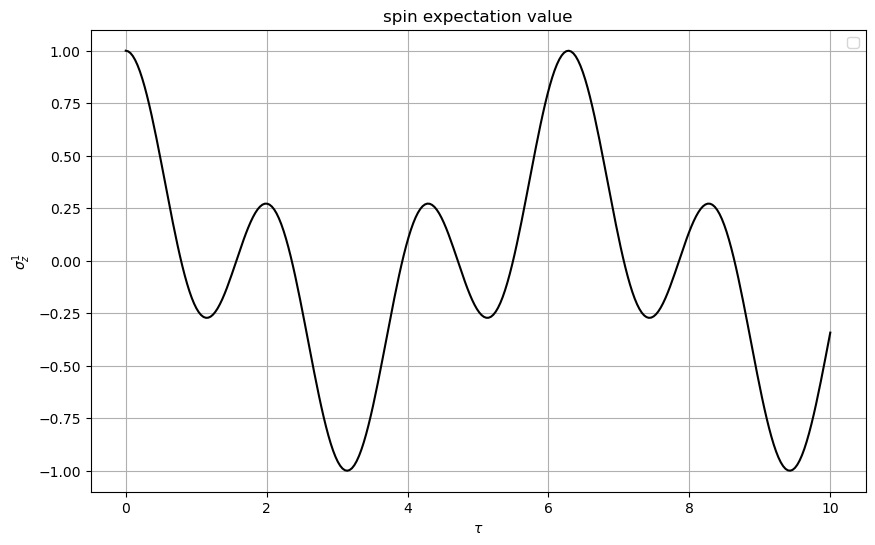

In [16]:
tlist = np.linspace(0, 10, 300)
omega = [1,1]
sys = N_dipole_system(2)

sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 1*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = sys.sz_list[0] 
observables = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables.append([expect(e_op, sys.states[-1])])

plt.figure(figsize=(10,6))
plt.plot(tlist, observables, color='black')
plt.grid(True)
plt.title('spin expectation value')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^{1}_{z}$')
plt.legend(loc='upper right')

Analytically calculate this evolution and plot result using mathematica:

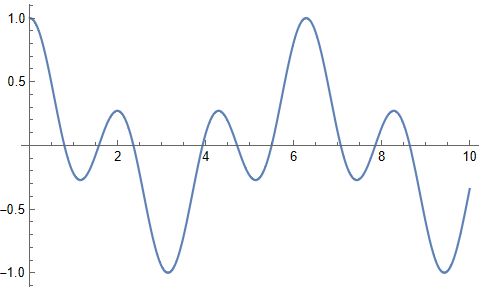

In [4]:
Image('Ramsey_analytical.png')

See dynamics of both spins in Bloch sphere. (More points of simulation are included.)

In [10]:
sys.states = [sys.ket_excited]  # initial state
sys.evolve_pulse(np.linspace(0,1,5), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
sys.evolve(np.linspace(0,t,50))
sys.evolve_pulse(np.linspace(0,1,5), Omega=[np.pi/2, np.pi/2])

sys.animate_bloch('Ramsey_yupeng.gif', duration=200)

C:\Users\chris\AppData\Local\Temp\ipykernel_26200\3317143189.py:102: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


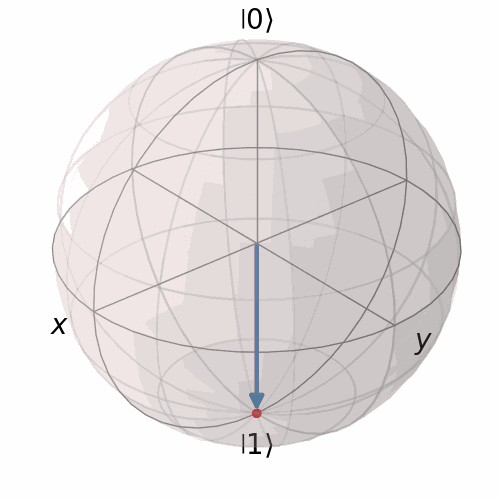

In [17]:
Image('Ramsey_yupeng.gif')

Apply spin echo sequence for both spins. $\sigma_z^1\sigma_z^2$ is preserved but $\sigma_z^1$ and $\sigma_z^2$ are not.

What's interesting is the frequency of $\sigma_z^1$ and $\sigma_z^2$ are dependent on interaction strength not spin frequencies.

Another notable point is that $\langle\sigma_z^1\sigma_z^2\rangle$ is not simple multiplication of $\langle\sigma_z^1\rangle$ and $\langle\sigma_z^2\rangle$.

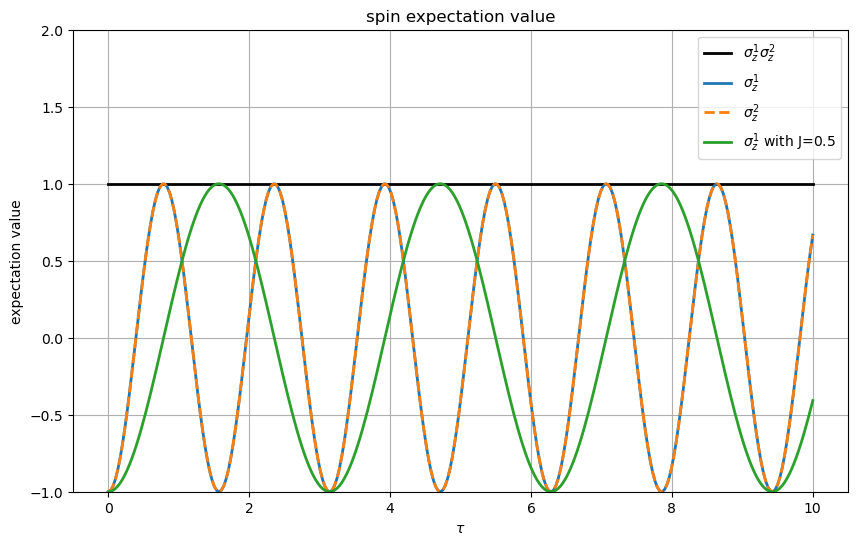

In [14]:
tlist = np.linspace(0, 10, 300)
omega = [1,1]
sys = N_dipole_system(2)

sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 1*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = [sys.sz_list[0]*sys.sz_list[1],sys.sz_list[0],sys.sz_list[1]]
observables0 = []
observables1 = []
observables2 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables0.append([expect(e_op[0], sys.states[-1])])
    observables1.append([expect(e_op[1], sys.states[-1])])
    observables2.append([expect(e_op[2], sys.states[-1])])



sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 0.5*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = [sys.sz_list[0]*sys.sz_list[1],sys.sz_list[0],sys.sz_list[1]]
observables3 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables3.append([expect(e_op[1], sys.states[-1])])



plt.figure(figsize=(10,6))
plt.plot(tlist, observables0, lw=2, label='$\sigma_z^1\sigma_z^2$', color='black')
plt.plot(tlist, observables1, lw=2, label='$\sigma_z^1$')
plt.plot(tlist, observables2, '--', lw=2, label='$\sigma_z^2$')
plt.plot(tlist, observables3, lw=2, label='$\sigma_z^1$ with J=0.5')

plt.ylim(-1,2)
plt.grid(True)
plt.title('spin expectation value')
plt.xlabel(r'$\tau$')
plt.ylabel(r'expectation value')
plt.legend(loc='upper right')


Can we extract frequency of first spin using some sequence? 

(With intuition) I chose a '$\frac{\pi}{2}$ - evolve - $\frac{\pi}{2}$' sequence for the first spin and 'evolve - $\pi$ - evolve' sequence for the second spin and measure $\sigma_z$ for the first atom. 

$\langle\sigma_z^1\rangle$ is invariant under different interaction strength J. However this is twice the frequence of the spin.

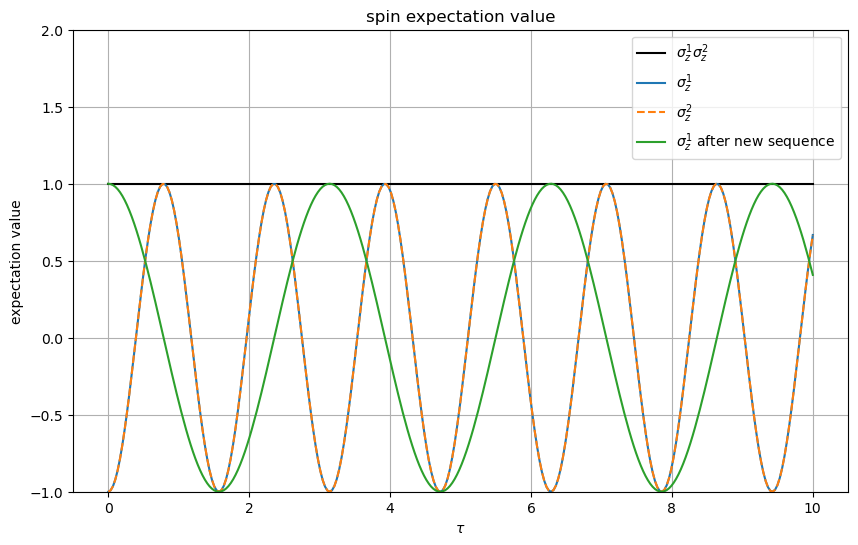

In [15]:
tlist = np.linspace(0, 10, 300)
omega = [1,1]
sys = N_dipole_system(2)

sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 1*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = [sys.sz_list[0]*sys.sz_list[1],sys.sz_list[0],sys.sz_list[1]]
observables0 = []
observables1 = []
observables2 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables0.append([expect(e_op[0], sys.states[-1])])
    observables1.append([expect(e_op[1], sys.states[-1])])
    observables2.append([expect(e_op[2], sys.states[-1])])



sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 6*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

observables3 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, 0])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[0, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, 0])
    observables3.append([expect(e_op[0], sys.states[-1])])


    
plt.figure(figsize=(10,6))
plt.plot(tlist, observables0, label='$\sigma_z^1\sigma_z^2$', color='black')
plt.plot(tlist, observables1, label='$\sigma_z^1$')
plt.plot(tlist, observables2, '--', label='$\sigma_z^2$')
plt.plot(tlist, observables3, label='$\sigma_z^1$ after new sequence')

plt.ylim(-1,2)
plt.grid(True)
plt.title('spin expectation value')
plt.xlabel(r'$\tau$')
plt.ylabel(r'expectation value')
plt.legend(loc='upper right')
